In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.inspection import permutation_importance
import shap
import pickle
import os

# Generate synthetic data
data, name_map = util.generate_data(size=500, seed=42)
num_cols = [c for c in data.columns[:-1] if len(data[c].unique()) > 2]
cat_cols = [c for c in data.columns[:-1] if len(data[c].unique()) == 2]

# Data pre-processing
X, y = data[data.columns[:-1]].copy(), data[data.columns[-1]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train a GBT model
base_est = xgboost.XGBClassifier(tree_method='hist', importance_type='total_gain')
param_grid={'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 41, 5)), 'reg_lambda': np.linspace(0, 500, 6)}
gscv = GridSearchCV(base_est, param_grid=param_grid)
gscv.fit(X, y)
xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

/Users/michelelombardi/Library/Caches/pypoetry/virtualenvs/06-at-RVmPecHn-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Additive Feature Attribution

## What we Gained, What we Lost

**When we switched from Logistic Regression to GBTs we gained a lot**

* A reliable proxy model
* A well defined and transparent feature importance definition
* Sparse and reliable importance scores

**However, we also lost something:**

With Linear Regression, we used to be able to:

* Identify the _direction_ of the correlation (through the coefficient sign)
* ...And explain _individual examples_, by looking at the difference:

$$
\theta^T x - \mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]
$$

## Explaining Individual Examples

**Let's look again at the last equation:**

$$
\theta^T x - \mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]
$$

* Assuming $P(X)$ is approximated by using a sample...
* ...Then $\mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]$ is just the average prediction on the data

we can re-write the previous equation as(?):
$$
\hat{y}_i = \Delta_i + \mathbb{E}\left[ \hat{y} \right]
$$

I.e. it is the prediction we could make _without access to any input value_

**Therefore, the difference above represents the gap between:**

* ...What we can predict given all information on one example
* ...And what we can predict with no such information

It's the collective _value of all available information_

## Explaining Individual Examples

**Due to linearity, the formula can be rewritten as:**

$$\begin{align}
\theta^T x - \mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right] & = \theta^T (x - \mathbb{E}_{x^\prime \in P(X)}[x^\prime]) \\
& = \sum_{j = 1}^n \theta_j (x_{j} - \mathbb{E}_{x_j^\prime \in P(X_j)}[x_j^\prime])
\end{align}$$

Meaning that we can assign a value _to every input attribute_:

* If we know the attribute, the model output moves from the trivial prediction
* ...And the change is given by $\phi_{j}(x) = \theta_j (x_{j} - \mathbb{E}_{x_j^\prime \in P(X_j)}[x_j^\prime])$

We call $\phi_{j}(x)$ the _effect_ of attribute $j$ for the example $x$

**Can we generalize this process to non-linear models?**

## Additive Feature Attribution

**Given an example $x$, we can try to build an additive attribution model:**

$$
g(z, x) = \phi_0 + \sum_{j = 1}^n \phi_{j}(x) z_j \quad\text{with: } z_{j} \in \{0, 1\}
$$

* Where $z_j$ is called a _simplified input_
* ...And represents the fact that the $j$-th attribute is known or unknown

**Intuitively, we build a linear explaination for the model local behavior**

* Several ML explainability approaches can be seen as attempts at this
* ...Most notably the original LIME method

## Shapely Values

**How do we build the additive attribution model?**

* We've already seen how to do it for linear models
* ...But for non-linear models the input features _interact_ with each other

**A possible solution: _marginalizing_ over all subset of remaining features**

Let $\mathcal{X}$ be the set of all input features; then we have:

$$
\phi_{j}(x) = \sum_{\mathcal{S} \subset \mathcal{X} \setminus j}
    \frac{|\mathcal{S}|! (n - |\mathcal{S}| - 1)!}{n!} (\hat{f}(x_{\mathcal{S} \cup j}) - \hat{f}(x_{\mathcal{S}}))
$$

* The sum is over all subsets that do not contain feature $j$
* The coefficient ensures normalization
* $\hat{f}(x_{\mathcal{S}})$ is the model evaluate with only features in $\mathcal{S}$

## Shapely Values

**The result of our marginalization:**

$$
\phi_{j}(x) = \sum_{\mathcal{S} \subset \mathcal{X} \setminus j}
    \frac{|\mathcal{S}|! (n - |\mathcal{S}| - 1)!}{n!} (\hat{f}(x_{\mathcal{S} \cup j}) - \hat{f}(x_{\mathcal{S}}))
$$

...Are known as _Shapely values_

* They originate from game theory
* ...In a setup where we want to assign credit to multiple actors for a result
* The actors correspond to our input features, the result to the model output

**Shapely values are the _only_ attribution model with some key properties**

## SHAP

**Using Shapely values for explanation become prominent with [this paper](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)**

The work makes a number of contributions:

* It introduces the general idea of additive feature attribution
* It shows how several previous approaches fall into that category
* It show how Shapely values provide "ideal" attribution scores
* It introduces multiple techniques to approximate the values

**Computing Shapely values can be very expensive, for two reasons:**

* There is exponential number of terms in the sum
* Many ML models do not support missing values

## Kernel SHAP

**Those issues can be sidestepped by learning a _local linear approximator_**

Given an example $x$, we can:

* Sample multiple simplified vectors $z^\prime$ of simplified inputs $z$ from $\{0, 1\}^{n}$
* For every sampled vector, we construce an example:
  - Forall $j$ s.t. $z_j^\prime = 1$, we put $x^\prime_j = x_j$ in the example
  - We sample all $x^\prime$ s.t. $z_j^\prime = 0$ from a _background set_
* We train a particular type of linear model on the obtained examples
* ...Then we compute the Shapely values using the linear formula

**By sampling from the background we marginalize out "missing" attributes**

Typically, we use as a background the training set or a sample of that

## Kernel SHAP

**The method we have just described is referred to as Kernel-SHAP**

It works even if we used _kernels_ computed on the original features

* E.g. we can group multiple features, or apply non-linear transformations
* In that case, the Shapely values will apply to the kernels

**Other approximation/computation methods have been defined**

* DeepSHAP for Deep NNs
* TreeSHAP for tree models
* ...

**Note:** beware of TreeShap, it is fast an exact, but it _relies on a slighly different semantic_! Be sure to understand the method you choose to use

## SHAP in Action

**The authors of the SHAP paper maintain [a nice Python package](https://github.com/shap/shap)**

...Which we are going to use to _explain_ our non-linear model

In [ ]:
f = lambda x: xbm.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, shap.sample(X_train, 100), link='logit') # we tell the library that we need it to explain the logit
shap_values = explainer(X_test)
with open(os.path.join('..', 'data', 'shap_values.pickle'), 'wb') as fp:
    pickle.dump(shap_values, fp)

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.82it/s]


* We'll focus on the _test_ data, since we want to find the true correlates
* For classifiers, it easier to explain _logits_ rather than probabilities
* The process can be slow, and using a small backgrond set is recommended
* The result contains the Shapely values, the base values, and the original data

## Waterfall Plots

**The SHAP library allows us to build _waterfall plots_**

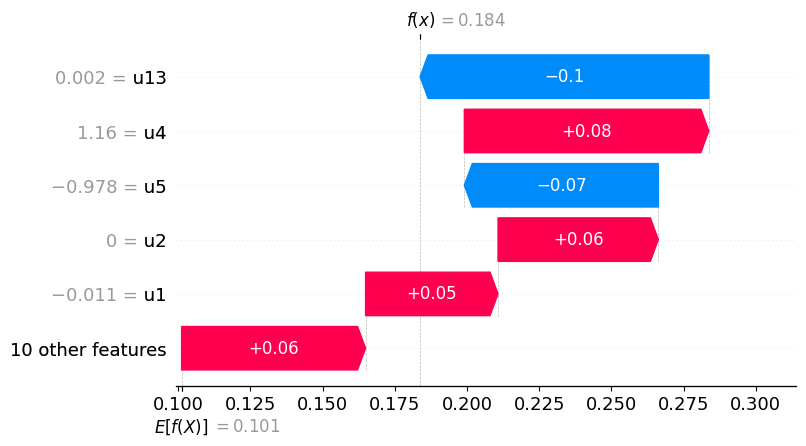

In [3]:
shap.plots.waterfall(shap_values[0], max_display=6)

* The bars represent the Shapely values, the colors their sign

This is the baseline prediction: 
- this means that the fact that the feature $u13$ was equal to $0.002$ means a decrease for the classification of $-0.1$
- at the end we see the feature with the smaller impact on this particular prediction all toghether with their total impact ($+0.06$)

## Force Plots

**Waterfall plots can be "compacted" into _force plots_**

Here we have again a plot for example 0:

In [4]:
shap.initjs()
shap.plots.force(shap_values[0])

...And have a plot for example 99

In [5]:
shap.plots.force(shap_values[99])

## Global Force Plots

**Force plots can be stacked to inspect many examples at once:**

In [6]:
shap.plots.force(shap_values)

## Scatter Plots

**We can use _scatter plots_ to show the effect of a single feature**

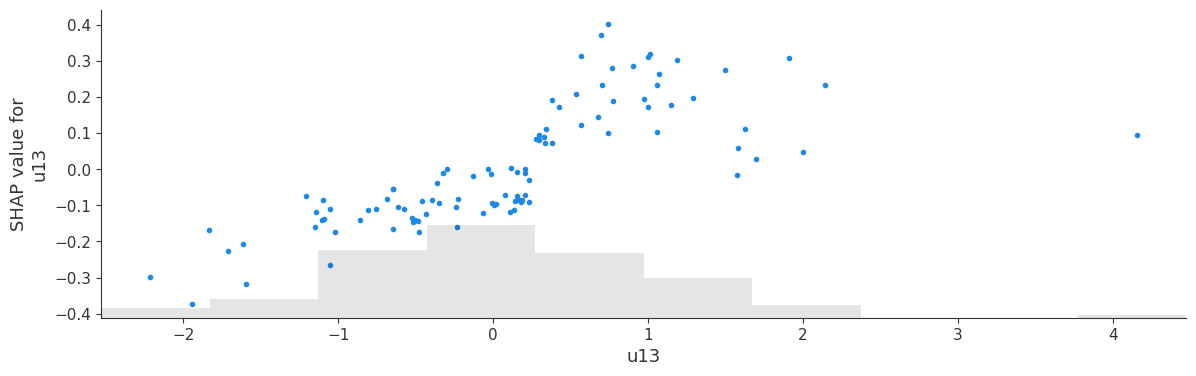

In [7]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u13'], ax=plt.gca())

* The gray area is the histogram of the chosen feature

## Beeswarm (Summary) Plot

**We can stack (and color) multiple scatter plots to obtain a _beeswarm_ plot:**

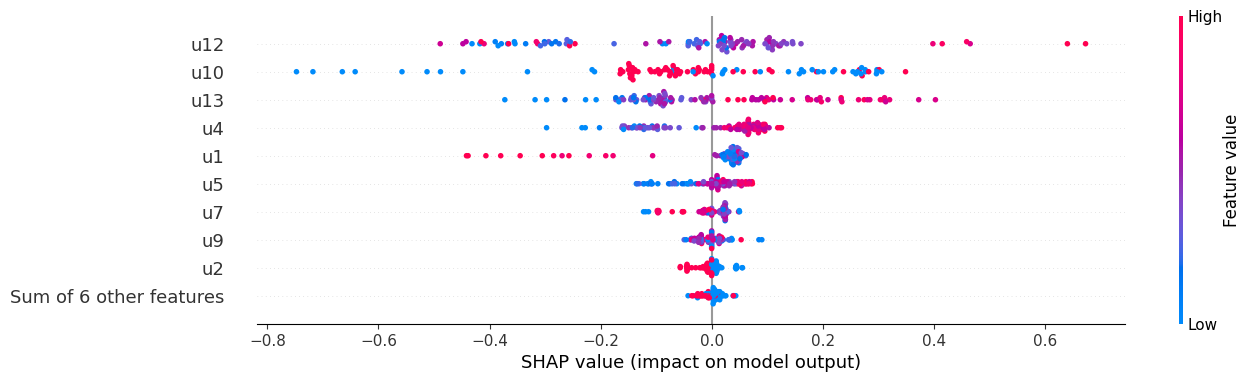

In [8]:
shap.plots.beeswarm(shap_values, max_display=10, plot_size=figsize)

* By checking the color distribution we can indentify (e.g.) monotonic effects

## Scatter (Dependency) Plots

**We can color scatter plots _by using another feature_ to highlight dependency**

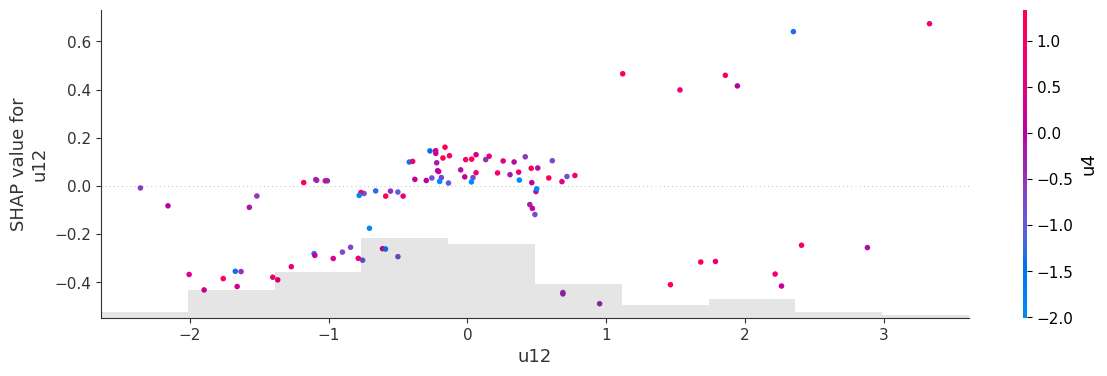

In [9]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u12'], color=shap_values[:, 'u4'], ax=plt.gca())

* In this case we are coloring the "u12" values by using "u4"

## Scatter (Dependency) Plots

**We can let the library choose the best coloring feature**

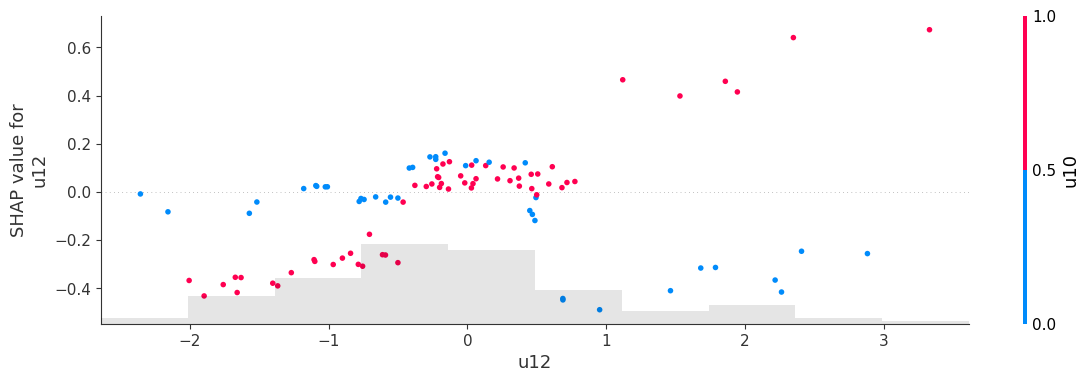

In [10]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u12'], color=shap_values, ax=plt.gca())

* The chosen coloring feature changes how "u12" impacts the output in a noticeable way